In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/is-this-sentence-completed/finished_sentences.csv
/kaggle/input/is-this-sentence-completed/finished_sentences.json


# About the Data
The data set I used is called is-this-sentence-completed. The data is in a simple csv file with two important columns. The column 'sentence' contains a sentence, complete or not, and the column is_finished is a boolean of wheter or not the sentence is complete. 

In [6]:
# some necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import pandas as pd

# set seed for reproducibility
np.random.seed(1234)

In [7]:
#Read Dataset
df = pd.read_csv('/kaggle/input/is-this-sentence-completed/finished_sentences.csv')
#Print Sample of Dataset
df.head()


,sentence,is_finished
0,"Apple supplier AMS cuts forecast, indicating p...",Finished
1,U.S. factory and services activity quicken in ...,Finished
2,Exclusive: Tesla expects global shortage of el...,Unfinished
3,"World stocks climb on China trade relief, whil...",Finished
4,"Boeing, J&J, dismal China data drag Wall Stree...",Finished


In [8]:
#Divide df into train/test
i = np.random.rand(len(df)) < 0.8
train = df[i]
test = df[~i]
print("train data size: ", train.shape)
print("test data size: ", test.shape)

train data size:  (42493, 2)
test data size:  (10656, 2)


# Graph Representation of Data

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: could not convert string to float: 'Finished'

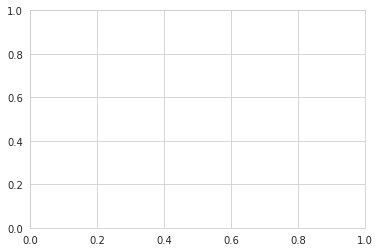

In [23]:
#graph
import seaborn as sns 
import matplotlib.pyplot as plt 
from warnings import filterwarnings

countFinished = 0
countNot = 0
for f in df.is_finished:
    if f:
        countFinished += 1 
    else:
        countNot += 1
sns.set_style('whitegrid')
sns.distplot(df['is_finished'], kde = False, color = 'red', bins = 30)

In [31]:
#Prepare X and Y data
num_labels = 2
vocab_size = 20000
batch_size = 128
#fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.sentence)
x_train = tokenizer.texts_to_matrix(train.sentence, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test.sentence, mode='tfidf')

encoder = LabelEncoder()
encoder.fit(train.is_finished)
y_train = encoder.transform(train.is_finished)
y_test = encoder.transform(test.is_finished)

# check shape
print("train shapes:", x_train.shape, y_train.shape)
print("test shapes:", x_test.shape, y_test.shape)
print("test first five labels:", y_test[:5])

train shapes: (42551, 20000) (42551,)
test shapes: (10598, 20000) (10598,)
test first five labels: [0 1 0 0 0]


# Sequential Model

In [32]:
#fit Sequential model
model = models.Sequential()
model.add(layers.Dense(32, input_dim=vocab_size, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Compile
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics='accuracy')

In [35]:
#Train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
266/266 [==============================] - 4s 15ms/step - loss: 0.4708 - accuracy: 0.7953 - val_loss: 0.4411 - val_accuracy: 0.8018
Epoch 2/10
266/266 [==============================] - 3s 11ms/step - loss: 0.3636 - accuracy: 0.8101 - val_loss: 0.4437 - val_accuracy: 0.8064
Epoch 3/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2478 - accuracy: 0.8885 - val_loss: 0.4799 - val_accuracy: 0.8011
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.1490 - accuracy: 0.9462 - val_loss: 0.5439 - val_accuracy: 0.7994
Epoch 5/10
266/266 [==============================] - 3s 11ms/step - loss: 0.0879 - accuracy: 0.9749 - val_loss: 0.6147 - val_accuracy: 0.7981
Epoch 6/10
266/266 [==============================] - 4s 14ms/step - loss: 0.0524 - accuracy: 0.9891 - val_loss: 0.6816 - val_accuracy: 0.7940
Epoch 7/10
266/266 [==============================] - 3s 12ms/step - loss: 0.0323 - accuracy: 0.9953 - val_loss: 0.7470 - val_accuracy: 0.7924

In [36]:
from sklearn.metrics import classification_report

In [37]:
pred = model.predict(x_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      8520
           1       0.46      0.34      0.39      2078

    accuracy                           0.79     10598
   macro avg       0.65      0.62      0.63     10598
weighted avg       0.77      0.79      0.78     10598



# Embedding Layers

In [ ]:
# set up the Embedding layer in a Sequential model

model = models.Sequential()
model.add(layers.Embedding(vocab_size, 8))
model.add(layers.Flatten())
model.add(layers.Dense(32, input_dim=vocab_size, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='acc')
model.summary()



In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

# Simple RNN Model

In [42]:
#fit RNN model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 32))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1,activation='sigmoid'))

In [43]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 642,113
Trainable params: 642,113
Non-trainable params: 0
_________________________________________________________________


In [44]:
#Compile
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics='accuracy')

In [ ]:
#Train
history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs = 10,
                    validation_split=0.2)

To train this simpleRNN in my attempts took a very long time, so that model unfortunately did not complete.